In [1]:
import pandas as pd
import numpy as np

# Define the possible conditions and diagnoses
diagnoses = [
    'Healthy', 'Fall Armyworm', 'Maize Stem Borer',
    'Northern Leaf Blight', 'Maize Lethal Necrosis', 'Drought Stress'
]

crop_stages = ['Seedling', 'Vegetative', 'Flowering', 'Maturity']

# Set the number of samples
num_samples = 2000

# Create a dictionary to hold the data
data = {
    'Temperature': np.random.uniform(22, 35, num_samples),
    'Humidity': np.random.uniform(50, 95, num_samples),
    'Rainfall_mm': np.random.uniform(0, 25, num_samples),
    'Crop_Stage': np.random.choice(crop_stages, num_samples),
    'Symptom_Leaf_Spots': np.random.randint(0, 2, num_samples),
    'Symptom_Holes_in_Leaves': np.random.randint(0, 2, num_samples),
    'Symptom_Stunted_Growth': np.random.randint(0, 2, num_samples),
    'Symptom_Wilting': np.random.randint(0, 2, num_samples),
    'Symptom_Stem_Boring': np.random.randint(0, 2, num_samples),
    'Diagnosis': [''] * num_samples
}

df = pd.DataFrame(data)

# --- Generate logical data based on known agricultural facts ---

# Northern Leaf Blight (high humidity, moderate temp)
condition = (df['Humidity'] > 75) & (df['Temperature'] < 30)
df.loc[condition, 'Symptom_Leaf_Spots'] = 1
df.loc[condition, 'Diagnosis'] = 'Northern Leaf Blight'

# Fall Armyworm (warmer temp, causes leaf holes)
condition = (df['Temperature'] > 28) & (df['Crop_Stage'].isin(['Vegetative', 'Flowering']))
df.loc[condition, 'Symptom_Holes_in_Leaves'] = 1
df.loc[condition, 'Diagnosis'] = 'Fall Armyworm'

# Maize Stem Borer (causes stem boring and stunting)
condition = (df['Temperature'] > 25) & (df['Crop_Stage'].isin(['Vegetative', 'Flowering']))
df.loc[condition, 'Symptom_Stem_Boring'] = 1
df.loc[condition, 'Symptom_Stunted_Growth'] = 1
df.loc[condition, 'Diagnosis'] = 'Maize Stem Borer'

# Drought Stress (high temp, low rain, causes wilting)
condition = (df['Temperature'] > 32) & (df['Rainfall_mm'] < 5)
df.loc[condition, 'Symptom_Wilting'] = 1
df.loc[condition, 'Symptom_Stunted_Growth'] = 1
df.loc[condition, 'Diagnosis'] = 'Drought Stress'

# Maize Lethal Necrosis (often severe stunting and leaf issues)
condition = (df['Humidity'] > 60) & (df['Temperature'] > 26) & (df['Crop_Stage'] != 'Maturity')
df.loc[condition, 'Symptom_Stunted_Growth'] = 1
df.loc[condition, 'Symptom_Leaf_Spots'] = 1
df.loc[condition, 'Symptom_Wilting'] = 1
df.loc[condition, 'Diagnosis'] = 'Maize Lethal Necrosis'

# Fill the rest with 'Healthy'
df.loc[df['Diagnosis'] == '', 'Diagnosis'] = 'Healthy'

# Shuffle the DataFrame to mix the data
df = df.sample(frac=1).reset_index(drop=True)

# Save to CSV
df.to_csv('maize_pests_data.csv', index=False)

print("Dataset created successfully with shape:", df.shape)
df.head()

Dataset created successfully with shape: (2000, 10)


,Temperature,Humidity,Rainfall_mm,Crop_Stage,Symptom_Leaf_Spots,Symptom_Holes_in_Leaves,Symptom_Stunted_Growth,Symptom_Wilting,Symptom_Stem_Boring,Diagnosis
0,30.348272,72.551848,10.282994,Maturity,1,0,1,0,1,Healthy
1,31.034394,81.370001,5.669688,Seedling,1,0,1,1,0,Maize Lethal Necrosis
2,34.416187,75.160986,0.896482,Vegetative,1,1,1,1,1,Maize Lethal Necrosis
3,32.231627,93.424520,13.247970,Maturity,1,0,0,0,1,Healthy
4,32.665036,61.827479,20.131828,Maturity,1,0,1,0,0,Healthy


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load data
df = pd.read_csv('maize_pests_data.csv')

# Convert categorical data to numerical format
# One-Hot Encode 'Crop_Stage' because there is no ordinal relationship
df = pd.get_dummies(df, columns=['Crop_Stage'], drop_first=True)

# Encode the target variable 'Diagnosis'
label_encoder = LabelEncoder()
df['Diagnosis'] = label_encoder.fit_transform(df['Diagnosis'])

# Separate features (X) and target (y)
X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (1600, 11)
Testing data shape: (400, 11)


Model Accuracy: 98.50%

Classification Report:
                        precision    recall  f1-score   support

       Drought Stress       1.00      0.50      0.67         8
              Healthy       0.97      0.99      0.98       121
Maize Lethal Necrosis       1.00      1.00      1.00       162
     Maize Stem Borer       0.96      1.00      0.98        44
 Northern Leaf Blight       1.00      0.98      0.99        65

             accuracy                           0.98       400
            macro avg       0.98      0.90      0.92       400
         weighted avg       0.99      0.98      0.98       400



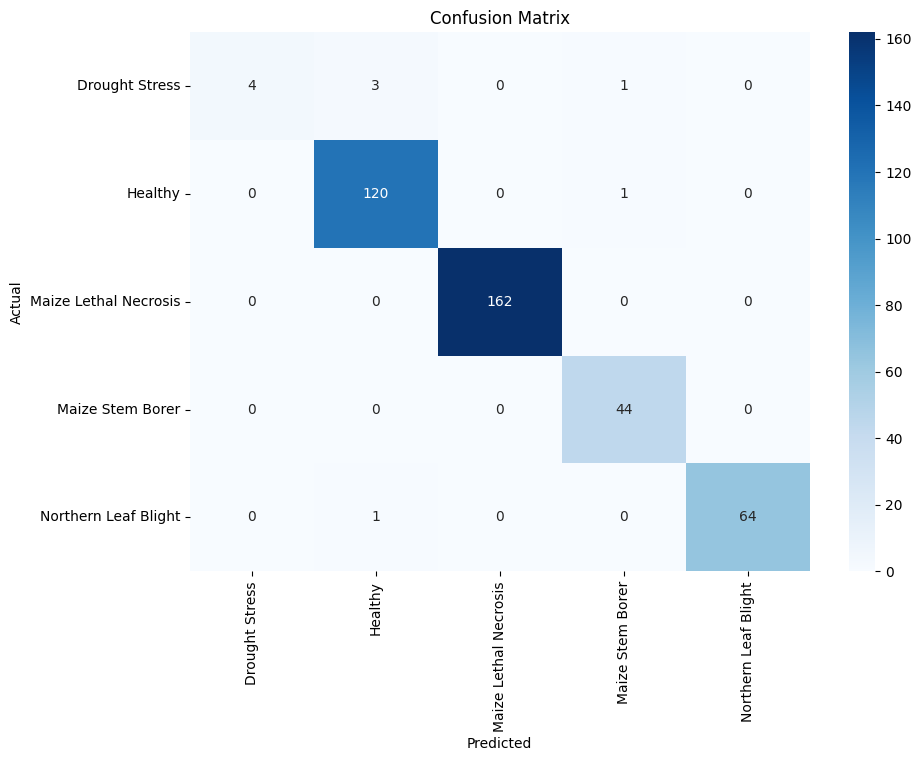

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize and train the model
model = RandomForestClassifier(n_estimators=100, random_state=42, oob_score=True)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [4]:
import joblib

# Save the trained model
joblib.dump(model, 'maize_dss_model.joblib')

# Save the label encoder
joblib.dump(label_encoder, 'label_encoder.joblib')

print("Model and encoder saved successfully.")

# To download the files from Colab
from google.colab import files
files.download('maize_dss_model.joblib')
files.download('label_encoder.joblib')
files.download('maize_pests_data.csv') # Optional: for reference

Model and encoder saved successfully.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>